In [22]:
import webrtcvad
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from pydub import AudioSegment
from IPython.display import Audio
import noisereduce as nr
import librosa

In [23]:
import os
import random

# Kiểm tra file từ một thư mục lệnh cụ thể
# data_dir = '../data/raw/bat_den'
# wav_files = [f for f in os.listdir(data_dir) if f.endswith('.wav')]
# filename = os.path.join(data_dir, random.choice(wav_files))


# Kiểm tra file ngẫu nhiên trong raw
data_dir = '../data/raw'
# Get all subdirectories (command folders)
command_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]

# Keep trying until we find a valid audio file
while True:
    # Randomly select a command directory
    command_dir = random.choice(command_dirs)
    command_path = os.path.join(data_dir, command_dir)
    
    # Get all wav files in this command directory
    wav_files = [f for f in os.listdir(command_path) if f.endswith('.wav')]
    
    # If we found wav files, break the loop
    if wav_files:
        data_dir = command_path
        break

filename = os.path.join(data_dir, random.choice(wav_files))
audio = AudioSegment.from_wav(filename).set_channels(1).set_frame_rate(16000)
raw_audio = np.array(audio.get_array_of_samples())
rate = audio.frame_rate
print(f"File name: {os.path.basename(filename)}")
print(f"Command folder: {os.path.basename(data_dir)}")

File name: bat_tv_speaker03_001.wav
Command folder: bat_tv


In [24]:
denoised_audio = nr.reduce_noise(y=raw_audio.astype(np.float32), sr=rate)

if rate != 16000:
    raw_audio = librosa.resample(raw_audio.astype(np.float32), orig_sr=rate, target_sr=16000)
    denoised_audio = librosa.resample(denoised_audio.astype(np.float32), orig_sr=rate, target_sr=16000)
    rate = 16000

# Thiết lập VAD
vad = webrtcvad.Vad(2)  # Aggressiveness 0-3

# Chia frame
frame_duration_ms = 30
frame_length = int(rate * frame_duration_ms / 1000)  # 480 samples cho 30ms @16kHz
frames = [denoised_audio[i:i+frame_length] for i in range(0, len(denoised_audio) - frame_length, frame_length)]

# Xử lý VAD
def is_speech(frame):
    int16_frame = (frame * 32768).astype(np.int16)
    return vad.is_speech(int16_frame.tobytes(), rate)

flags = [is_speech(frame) for frame in frames]
speech_mask = np.repeat(flags, frame_length)
speech_mask = np.pad(speech_mask, (0, len(denoised_audio) - len(speech_mask)), mode='constant')
speech_audio = denoised_audio * speech_mask


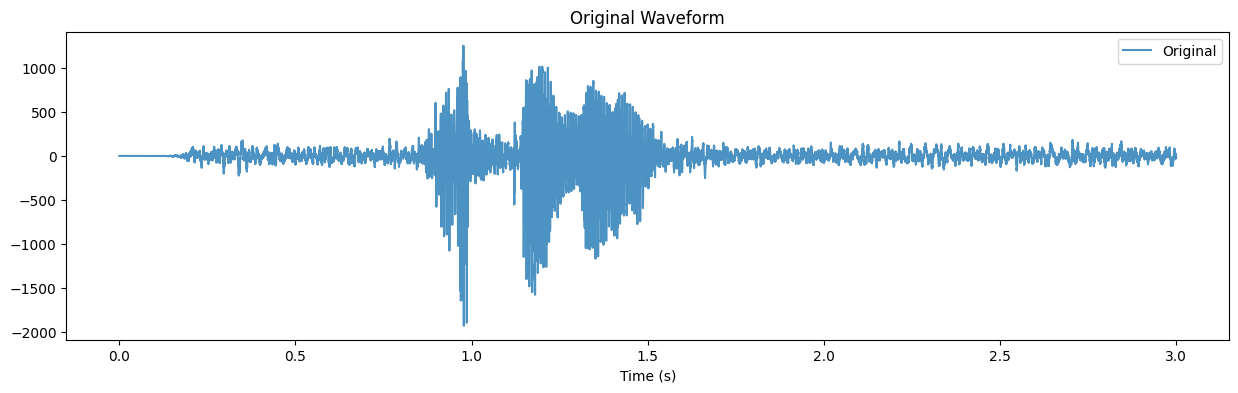

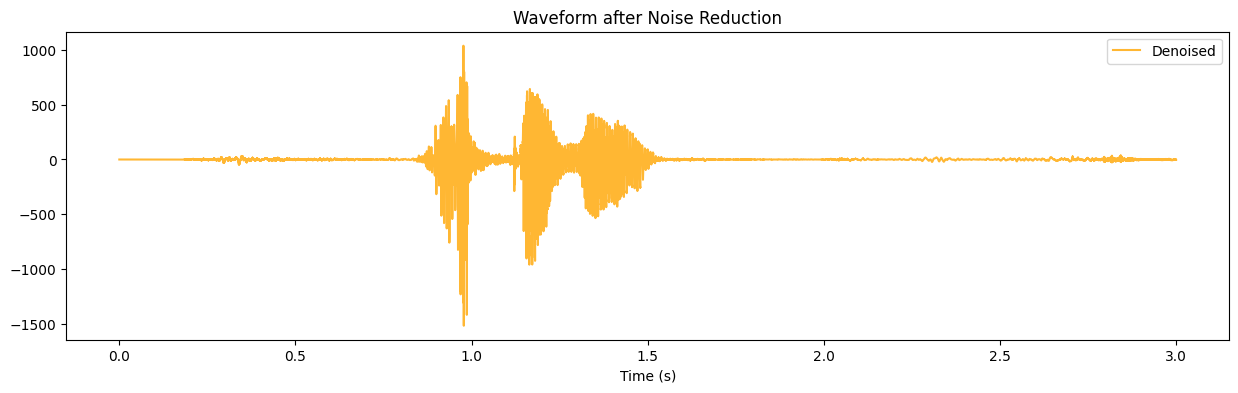

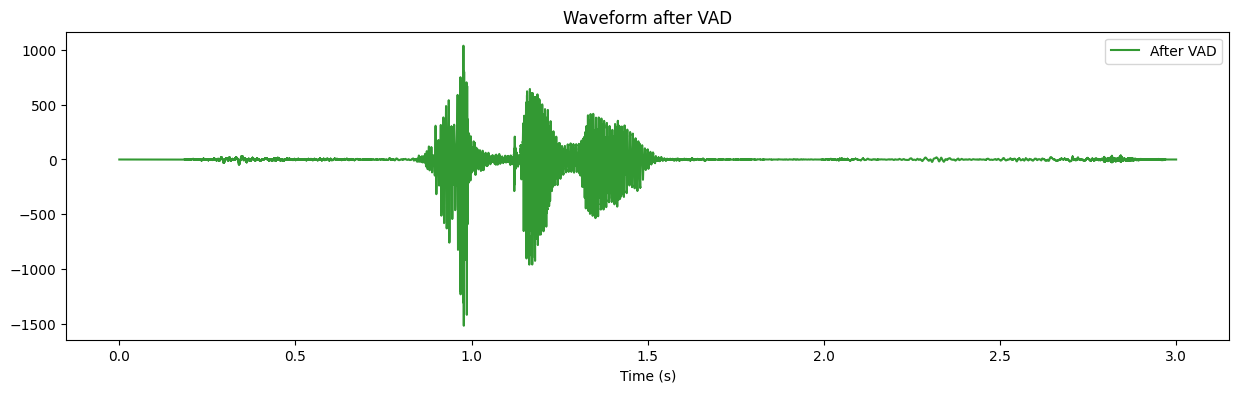

In [25]:
time = np.linspace(0, len(raw_audio)/rate, num=len(raw_audio))

# Plot original waveform
plt.figure(figsize=(15, 4))
plt.plot(time, raw_audio, label="Original", alpha=0.8)
plt.title("Original Waveform")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

# Plot denoised waveform
plt.figure(figsize=(15, 4))
plt.plot(time, denoised_audio, label="Denoised", alpha=0.8, color='orange')
plt.title("Waveform after Noise Reduction")
plt.xlabel("Time (s)")
plt.legend()
plt.show()

# Plot VAD output waveform
plt.figure(figsize=(15, 4))
plt.plot(time, speech_audio, label="After VAD", alpha=0.8, color='green')
plt.title("Waveform after VAD")
plt.xlabel("Time (s)")
plt.legend()
plt.show()


Selected segment energy: 464460032.0


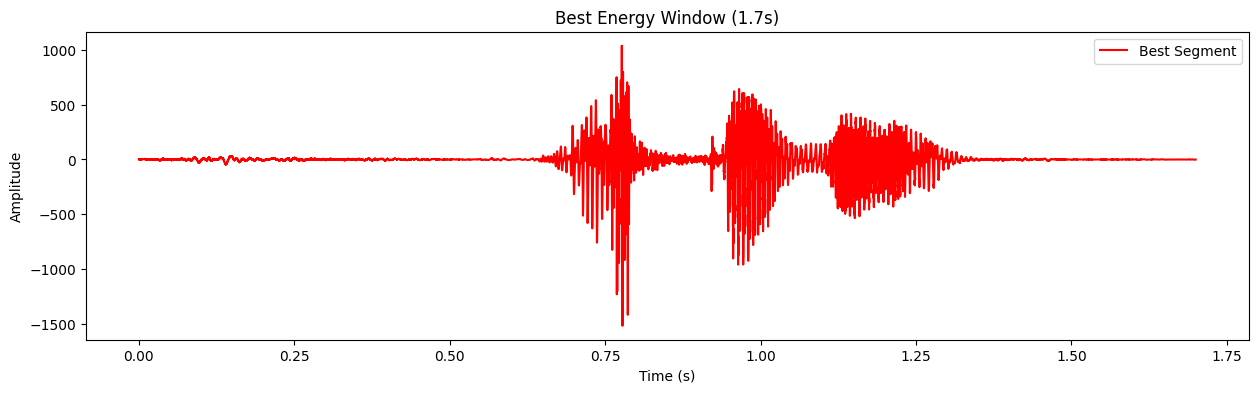

In [26]:
window_sec = 1.7
window_len = int(window_sec * rate)
stride = int(0.2 * rate)

max_energy = 0
best_segment = None

for i in range(0, len(speech_audio) - window_len, stride):
    window = speech_audio[i:i+window_len]
    energy = np.sum(window.astype(np.float32)**2)
    if energy > max_energy:
        max_energy = energy
        best_segment = window

print(f"Selected segment energy: {max_energy}")
# Plot the best segment waveform
time_best = np.linspace(0, len(best_segment)/rate, num=len(best_segment))

plt.figure(figsize=(15, 4))
plt.plot(time_best, best_segment, label="Best Segment", color='red')
plt.title("Best Energy Window (1.7s)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude") 
plt.legend()
plt.show()

# Play the audio
Audio(best_segment, rate=rate)


Cắt 0.2s đầu như mặc định.


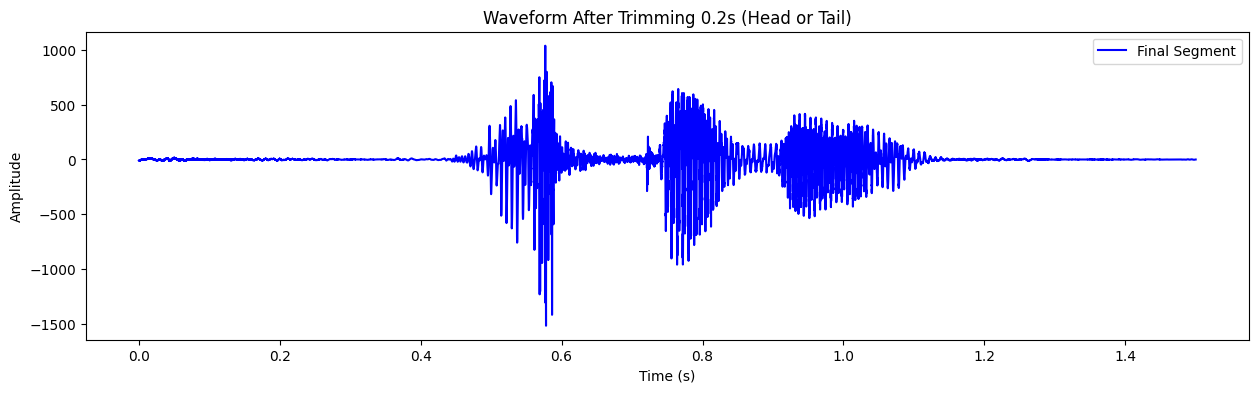

In [27]:
cut_sec = 0.2  # Thời gian cắt đầu hoặc cuối (0.2 giây)
cut_len = int(cut_sec * rate)
check_len = int(0.3 * rate)  # Kiểm tra 0.3s có năng lượng cao nhất
stride = int(0.01 * rate)

max_energy = 0
best_start = 0

# Bước 1: Tìm đoạn 0.3s có năng lượng cao nhất
for i in range(0, len(best_segment) - check_len + 1, stride):
    window = best_segment[i:i + check_len]
    energy = np.sum(window.astype(np.float32) ** 2)
    if energy > max_energy:
        max_energy = energy
        best_start = i

best_start_sec = best_start / rate  # Vị trí bắt đầu của đoạn có năng lượng cao

# Bước 2: Xử lý cắt 0.2s đầu hoặc cuối
if best_start_sec < 0.3:
    # Nếu đoạn có năng lượng cao nằm ở đầu (sau 0.05s) → cắt 0.2s cuối
    final_segment = best_segment[:-cut_len]
    print("Cắt 0.2s cuối vì đoạn có năng lượng cao nằm ở đầu.")
else:
    # Ngược lại, cắt 0.2s đầu như mặc định
    if len(best_segment) > cut_len:
        final_segment = best_segment[cut_len:]
    else:
        final_segment = best_segment  # fallback nếu quá ngắn
    print("Cắt 0.2s đầu như mặc định.")

# Vẽ waveform sau khi cắt
time_final = np.linspace(0, len(final_segment) / rate, num=len(final_segment))

plt.figure(figsize=(15, 4))
plt.plot(time_final, final_segment, label="Final Segment", color='blue')
plt.title("Waveform After Trimming 0.2s (Head or Tail)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# Nghe thử đoạn đã cắt
Audio(final_segment, rate=rate)


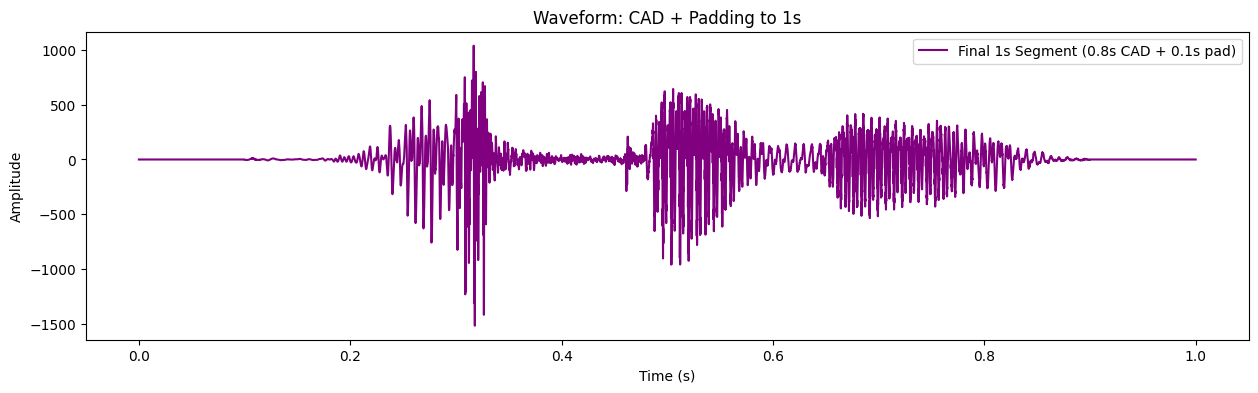

In [28]:
# --- Step 1: Tìm đoạn 0.8s có năng lượng cao nhất ---
cad_len = int(0.8 * rate)
stride = int(0.02 * rate)

max_energy = 0
best_start = 0

for i in range(0, len(final_segment) - cad_len + 1, stride):
    window = final_segment[i:i + cad_len]
    energy = np.sum(window.astype(np.float32) ** 2)
    if energy > max_energy:
        max_energy = energy
        best_start = i

cad_segment = final_segment[best_start:best_start + cad_len]

# --- Step 2: Pad đều 0.1s mỗi bên ---
pad_len = int(0.1 * rate)
padded_segment = np.pad(cad_segment, (pad_len, pad_len), mode='constant')

# --- Step 3: Vẽ waveform ---
time_padded = np.linspace(0, 1.0, num=len(padded_segment))

plt.figure(figsize=(15, 4))
plt.plot(time_padded, padded_segment, label="Final 1s Segment (0.8s CAD + 0.1s pad)", color='purple')
plt.title("Waveform: CAD + Padding to 1s")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

# --- Step 4: Nghe thử ---
Audio(padded_segment, rate=rate)